In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
import time
from tqdm import tqdm

from scipy import stats

plt.rcParams['font.size'] = 14

# sns.set_context('notebook', font_scale=1)
# sns.set_style('whitegrid')
# sns.set_palette('copper_r')

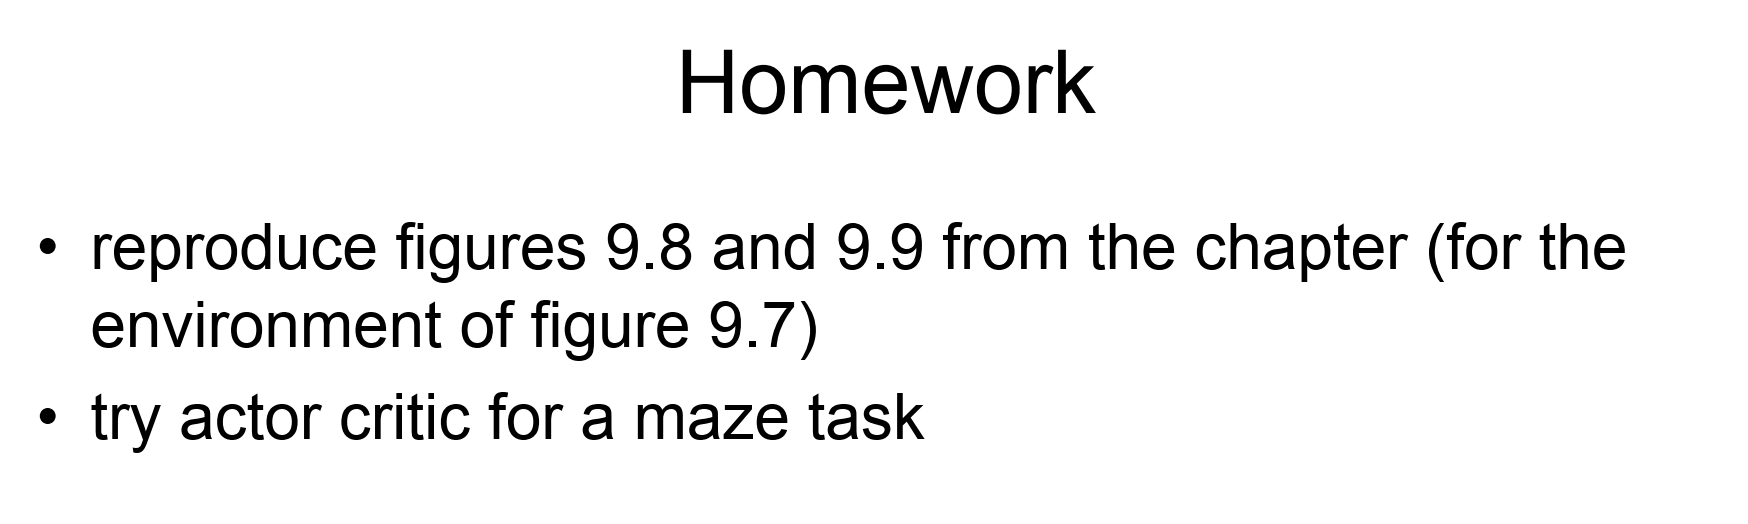

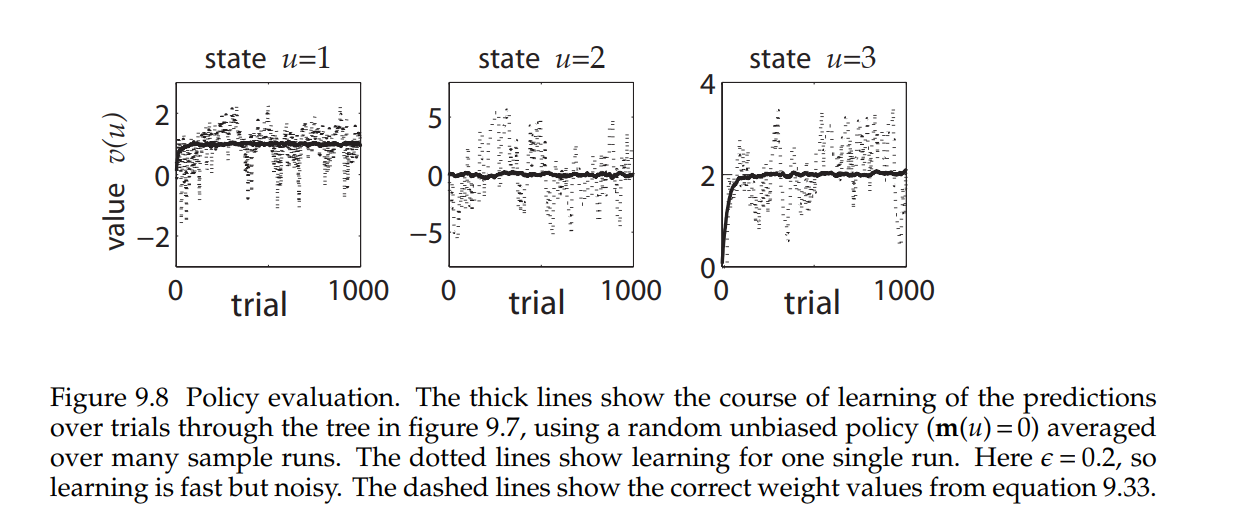

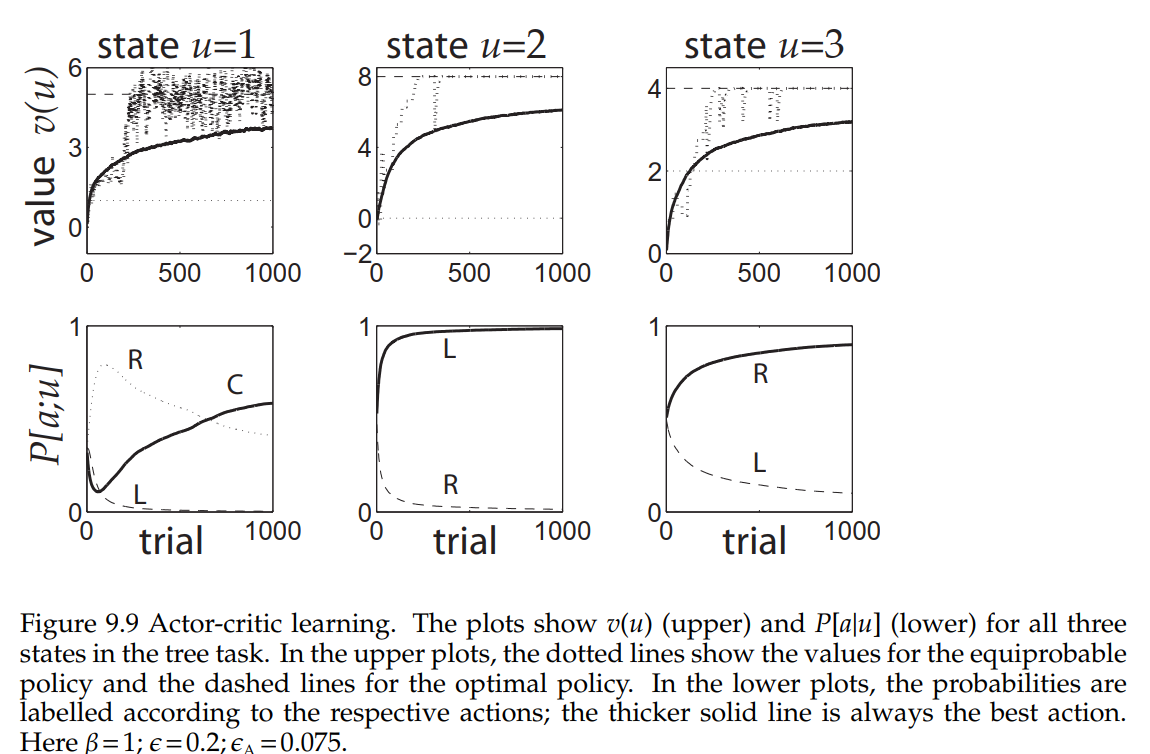

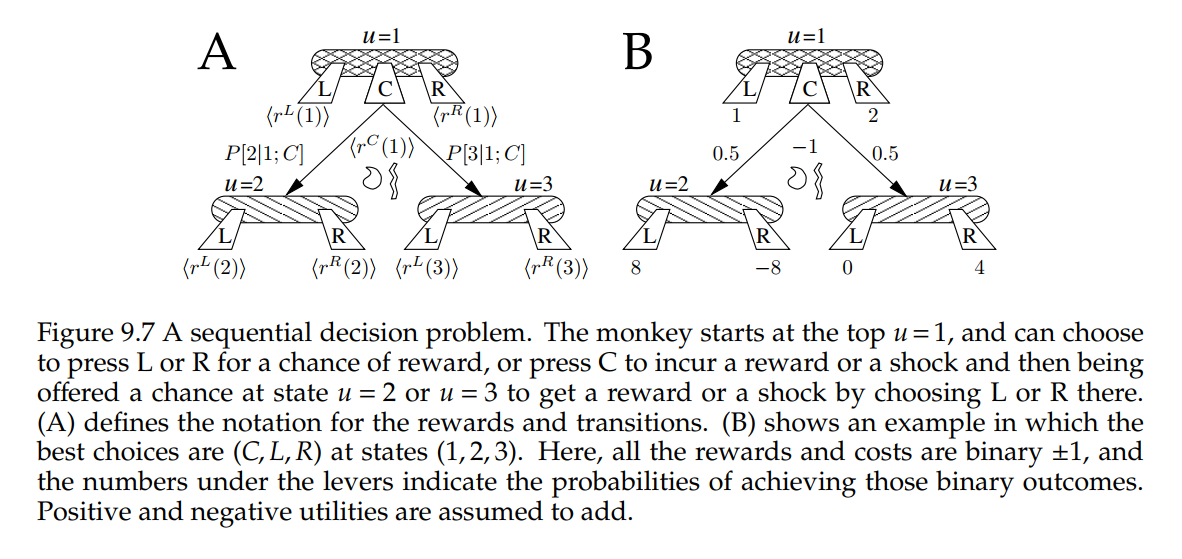

**Transition matrix**

$P(0 \rightarrow 1 | C) = 0.5$

$P(0 \rightarrow 2 | C) = 0.5$

### Policy evaluation (critic)

In [2]:
class ActorCriticLearner:
    
    def __init__(self, 
                 lr_actor=0.4, 
                 lr_critic=0.2, 
                 beta=1, 
                 states=[0, 1, 2], 
                 terminal_states=[3], 
                 actions=[0, 1, 2], 
                 reward_matrix=None, 
                 transition_matrix=None, 
                 allowed_actions_matrix=None,
                 policy='critic'):
        
        self.states  = np.array(states)   # u = 1, 2, 3
        self.actions = np.array(actions)  # a = L, C, R
        self.terminal_states = np.array(terminal_states)
        self.all_states = np.array(list(self.states) + list(self.terminal_states))
        
        # constants
        self.lr_actor = lr_actor
        self.lr_critic = lr_critic
        self.beta = beta
        
        # policy ""
        self.policy = policy  # critic or actor. critic uses random action policy while actor actually uses action-values and updates them
        
        
        # set arrays for internal use
        self.set_reward_matrix(reward_matrix)
        self.set_transition_matrix(transition_matrix)
        self.set_allowed_actions_matrix(allowed_actions_matrix)
        
        # record of values
        self.trialValues = []
        self.trialActionValues = []
        self.trialActionProbabilities = []
        
        
    def set_reward_matrix(self, reward_matrix=None):
        if reward_matrix is None:
            self.reward_matrix = np.array([[1, -1, 2], 
                                           [8, 0, -8], 
                                           [0, 0, 4]])
        else:
            self.reward_matrix = reward_matrix
            
            
    def set_transition_matrix(self, transition_matrix=None):
        if transition_matrix is None:
            P = np.zeros((len(self.all_states), len(self.actions), len(self.all_states))) 
            for state in self.states:
                if state == 1 or state == 2:
                    P[state, :, 3] = np.ones(len(self.actions)) # for any action get to the terminal state
                for action in self.actions:
                    if state == 0:
                        if action == 0:
                            P[state, action, 3] = 1
                        if action == 1:
                            P[state, action, 1] = 0.5
                            P[state, action, 2] = 0.5
                        if action == 2:
                            P[state, action, 3] = 1
                            
            transition_matrix = P
        self.transition_matrix = transition_matrix
            
            
    def set_allowed_actions_matrix(self, allowed_actions_matrix=None):
        """For each state the allowed actions will be marked True otherwise False (mask array) """
        if allowed_actions_matrix is None:
            A = np.ones((len(self.states), len(self.actions)), dtype=bool)
            A[1, 1] = False # for the second choice there is no "C" option
            A[2, 1] = False # for both leaves
            self.allowed_actions_matrix = A
        else:
            self.allowed_actions_matrix = allowed_actions_matrix


    def get_possible_actions(self, state):
        if state not in self.states:
            raise ValueError("Requested state must be in self.states.")
        return self.actions[self.allowed_actions_matrix[state]]
    
    
    def choose_action(self, state, action_values):
        possible_actions = self.get_possible_actions(state)
        if self.policy == 'critic':
            action = np.random.choice(possible_actions)
            return action
        if self.policy == 'actor':
            probs = self.softmax(action_values[state, possible_actions], beta=self.beta)
            action = np.random.choice(self.actions[possible_actions], p=probs)
            return action
    
    
    def action_values_to_probabilities(self, action_values):
        probs = np.zeros((len(self.states), len(self.actions)))
        for state in self.states:
            possible_actions = self.allowed_actions_matrix[state]
            probs[state, possible_actions] = self.softmax(action_values[state, possible_actions], self.beta)
        return probs
    
        
    def get_reward(self, state, action):    
        return self.reward_matrix[state, action]
    
    
    def get_next_state(self, state, action):
        return np.random.choice(self.all_states, p=self.transition_matrix[state, action, :]) 
        
        
    def oneTrial(self, verbose=False):
        
        # initialize values for the trial
        if len(self.trialValues) == 0: 
            values  = np.zeros(len(self.all_states))
            action_values = np.zeros(shape=(len(self.states), len(self.actions)))
        else:
            values = self.trialValues[-1]
            action_values = self.trialActionValues[-1]
        
        # go through the states
        current_state = 0
        while current_state not in self.terminal_states:
            
            # choose available action, get reward and next state
            action     = self.choose_action(current_state, action_values)
            reward     = self.get_reward(current_state, action) 
            next_state = self.get_next_state(current_state, action)
            
            # compute error
            error      = self.compute_error(reward, values[current_state], values[next_state])
            
            # update state values
            values[current_state] = self.update_critic(values[current_state], self.lr_critic, error)
            
            # update action values
            action_values = self.update_actor(action_values, current_state, action, self.get_possible_actions(current_state), self.lr_actor, error)
            current_state = next_state
            
            
            if verbose:
                print("action: ", action)
                print("reward: ", reward)
                print("next state: ", next_state)
                print("error: ", error)
                print("values: ", values)

        self.trialValues.append(values.copy())  
        self.trialActionValues.append(action_values.copy())
        self.trialActionProbabilities.append(self.action_values_to_probabilities(action_values.copy()))
    
    
    def learn(self, n_trials, verbose=False):
        for i_trial in range(n_trials):
            if verbose: print("Trial #: ", i_trial)
            self.oneTrial(verbose=verbose)
            
    @staticmethod          
    def compute_error(reward, current_value, next_value):
        return reward + next_value - current_value
            
    @staticmethod
    def update_critic(value, lr_critic, error):
        return value + lr_critic * error
    
    @staticmethod
    def update_actor(action_values, state, action, allowed_actions, lr_actor, error):
        new_action_values = action_values.copy()
        #new_action_values[state, allowed_actions] = (1 - lr_actor) * action_values[state, allowed_actions]
        new_action_values[state, action] += lr_actor * error
        return new_action_values
            
    @staticmethod        
    def softmax(m, beta=1):
        probs = np.exp(beta * m)
        return probs / np.sum(probs)
    

In [3]:
MP_CONTEXT = 'grayscale' # or dark_background

CPU times: total: 312 ms
Wall time: 343 ms


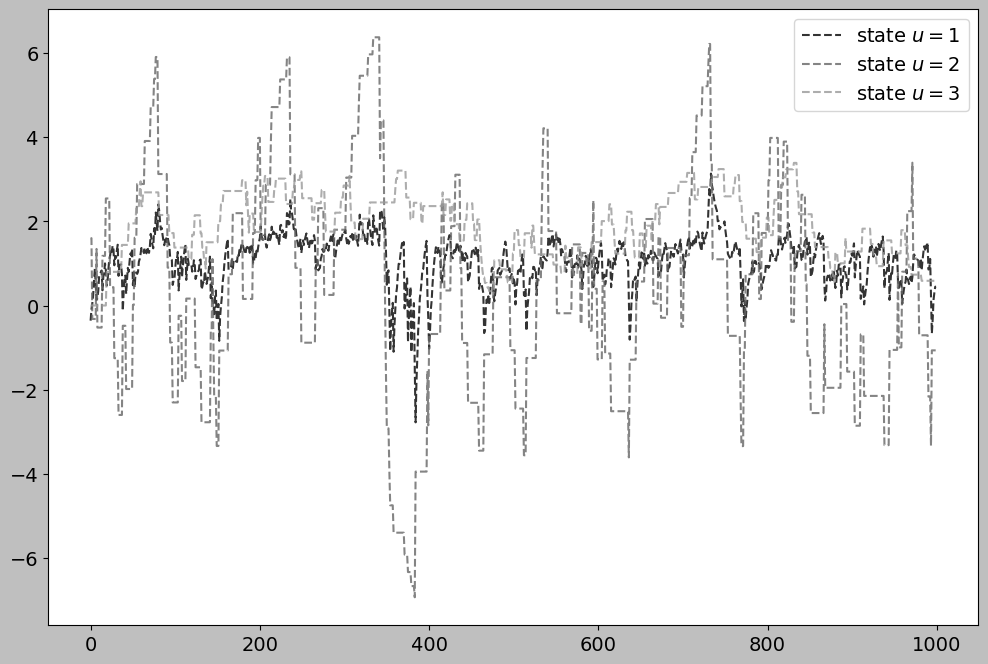

In [4]:
%%time
lr = 0.2
n_trials = 1000

agent = ActorCriticLearner(lr_critic=0.2, policy='critic')
agent.learn(n_trials=n_trials, verbose=False)

values = np.array(agent.trialValues)


with plt.style.context(MP_CONTEXT):
    plt.figure(figsize=(12, 8))
    plt.plot(values[:, 0], label=r"state $u=1$", linestyle='--', alpha=0.8)
    plt.plot(values[:, 1], label=r"state $u=2$", linestyle='dashed', alpha=0.8)
    plt.plot(values[:, 2], label=r"state $u=3$", linestyle="--", alpha=0.8)
    plt.legend()

In [28]:
%%time
n_epochs = 1000

epochValues = np.zeros((n_epochs, n_trials, len(agent.all_states)))
for i in tqdm(range(n_epochs), desc='epoch: '):
    agent = ActorCriticLearner(policy='critic')
    agent.learn(n_trials=n_trials, verbose=False)
    epochValues[i] = np.array(agent.trialValues)

epoch: 100%|███████████████████████████████████████████████████████████████████████| 1000/1000 [03:29<00:00,  4.77it/s]

CPU times: total: 3min 29s
Wall time: 3min 29s


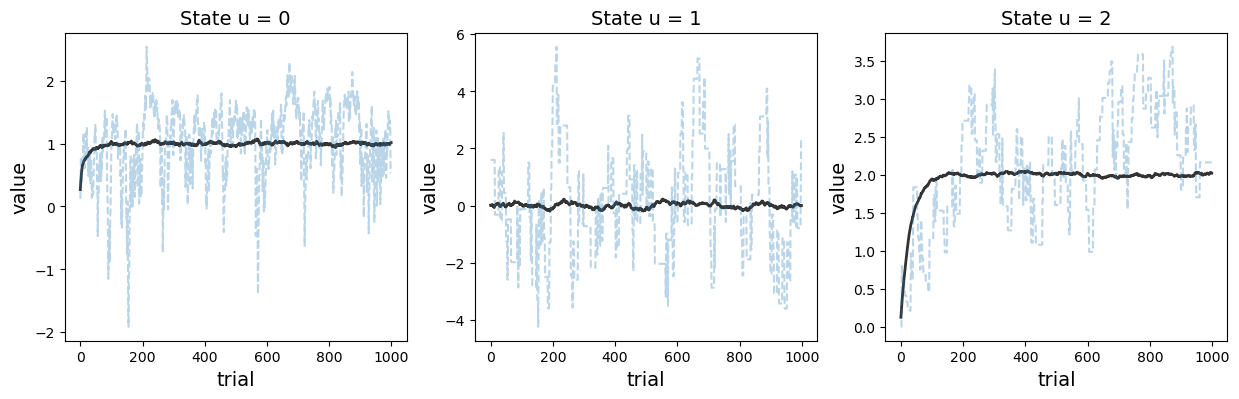

In [30]:
%matplotlib inline
values = epochValues.mean(axis=0)

plt.rc('font', family='sans-serif', size=12)
FONTSIZE = 14

with plt.style.context('default'):
    
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    for i_state in [0, 1, 2]:
        ax = axes[i_state]
        ax.plot(values[:, i_state], color='black', linewidth=2, alpha=0.8)
        ax.plot(epochValues[-1, :, i_state], linestyle='dashed', alpha=0.3)
        ax.set_xlabel("trial", fontsize=FONTSIZE)
        ax.set_ylabel("value", fontsize=FONTSIZE)
        ax.set_title(f"State u = {agent.states[i_state]}", fontsize=FONTSIZE)

    plt.savefig("hw02_figure1_random.png", dpi=150, bbox_inches='tight')

In [7]:
%%time
n_trials = 1000

agent = ActorCriticLearner(
                 lr_actor=0.8, 
                 lr_critic=0.2, 
                 beta=1, 
                 states=[0, 1, 2], 
                 terminal_states=[3], 
                 actions=[0, 1, 2], 
                 reward_matrix=None, 
                 transition_matrix=None, 
                 allowed_actions_matrix=None,
                 policy='actor')

agent.learn(n_trials=n_trials, verbose=False)

values = np.array(agent.trialValues)
with plt.style.context(MP_CONTEXT):
    plt.figure(figsize=(12, 8))
    plt.plot(values[:, 0], label=r"state $u=1$", alpha=0.8)
    plt.plot(values[:, 1], label=r"state $u=2$", linestyle='dashed', alpha=0.8)
    plt.plot(values[:, 2], label=r"state $u=3$", linestyle="--", alpha=0.8)
    plt.legend()

CPU times: total: 219 ms
Wall time: 221 ms


In [7]:
for i_trial in [0, n_trials // 2, n_trials-1]:
    print("trial #", i_trial)
    print(agent.trialActionValues[i_trial].round(2))

trial # 0
[[0.8 0.  0. ]
 [0.  0.  0. ]
 [0.  0.  0. ]]
trial # 500
[[ 0.8  -0.96  8.16]
 [ 6.4   0.    0.  ]
 [ 0.    0.    0.  ]]
trial # 999
[[ 0.8  -0.96  8.16]
 [ 6.4   0.    0.  ]
 [ 0.    0.    0.  ]]


In [8]:
for i_trial in [0, n_trials // 2, n_trials-1]:
    print("trial #", i_trial)
    print(agent.trialActionProbabilities[i_trial].round(2))

trial # 0
[[0.53 0.24 0.24]
 [0.5  0.   0.5 ]
 [0.5  0.   0.5 ]]
trial # 500
[[0.  0.  1. ]
 [1.  0.  0. ]
 [0.5 0.  0.5]]
trial # 999
[[0.  0.  1. ]
 [1.  0.  0. ]
 [0.5 0.  0.5]]


In [9]:

plt.plot(values[:, 0], label=r"state $u=1$", alpha=0.8)
plt.plot(values[:, 1], label=r"state $u=2$", linestyle='dashed', alpha=0.8)
plt.plot(values[:, 2], label=r"state $u=3$", linestyle="--", alpha=0.8)
plt.legend()

SyntaxError: invalid syntax (4054453501.py, line 1)

In [22]:
%%time
n_epochs = 100
n_trials = 1000

epochValues = np.zeros((n_epochs, n_trials, len(agent.all_states)))
epochProbabilites = np.zeros((n_epochs, n_trials, len(agent.states), len(agent.actions)))

for i in tqdm(range(n_epochs), desc='epoch'):
    agent = ActorCriticLearner(
                 lr_actor=0.15, 
                 lr_critic=0.2, 
                 beta=0.2, 
                 states=[0, 1, 2], 
                 terminal_states=[3], 
                 actions=[0, 1, 2], 
                 reward_matrix=None, 
                 transition_matrix=None, 
                 allowed_actions_matrix=None,
                 policy='actor')
    agent.learn(n_trials=n_trials, verbose=False)
    epochValues[i] = np.array(agent.trialValues)
    epochProbabilites[i] = np.array(agent.trialActionProbabilities)

epoch: 100%|█████████████████████████████████████████████████████████████████████████| 100/100 [00:30<00:00,  3.32it/s]

CPU times: total: 30 s
Wall time: 30.1 s


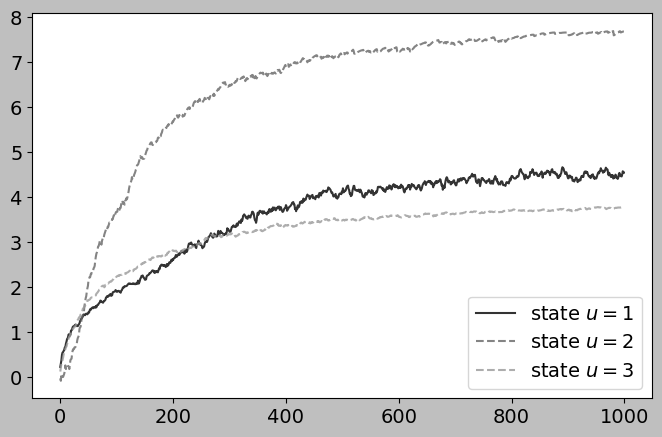

In [14]:
%matplotlib inline
values = np.array(epochValues.mean(axis=0))

with plt.style.context('grayscale'):
    plt.figure(figsize=(8, 5))
    plt.plot(values[:, 0], label=r"state $u=1$", alpha=0.8)
    plt.plot(values[:, 1], label=r"state $u=2$", linestyle='dashed', alpha=0.8)
    plt.plot(values[:, 2], label=r"state $u=3$", linestyle="--", alpha=0.8)
    plt.legend()

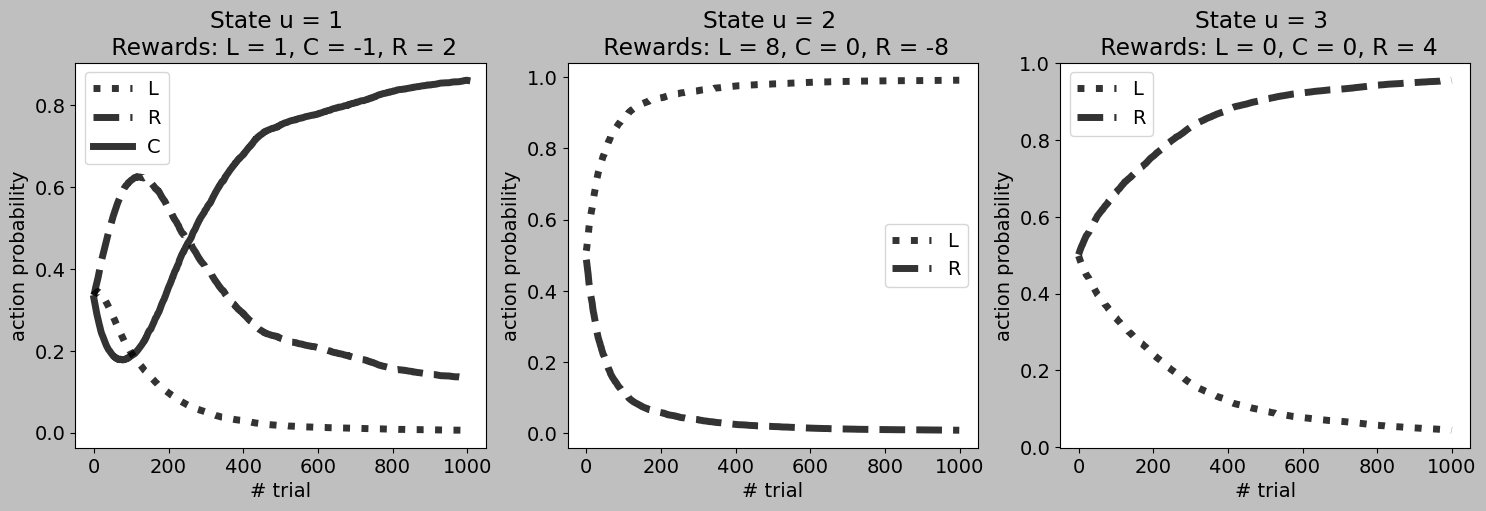

In [13]:
values = np.array(epochProbabilites.mean(axis=0))

action_to_index = {'L': 0, "C": 1, "R": 2}

linewidth = 5
color='black'

with plt.style.context('grayscale'):
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    for i_state in [0, 1, 2]:
        ax = axes[i_state]
        ax.plot(values[:, i_state, 0], label=r"L", linestyle=':', alpha=0.8, linewidth=linewidth, color=color)
        ax.plot(values[:, i_state, 2], label=r"R", linestyle="--", alpha=0.8, linewidth=linewidth, color=color)
        if i_state == 0:
            ax.plot(values[:, i_state, 1], label=r"C", linestyle='-', alpha=0.8, linewidth=linewidth, color=color)
        r = agent.reward_matrix[i_state]
        ax.set_title(f"State u = {i_state+1} \n Rewards: L = {r[0]}, C = {r[1]}, R = {r[2]}")
        ax.set_xlabel("# trial")
        ax.set_ylabel("action probability")
        ax.legend()
    plt.savefig("actor_critic_fig9.12.png", dpi=300, bbox_inches='tight')
        
    plt.show()

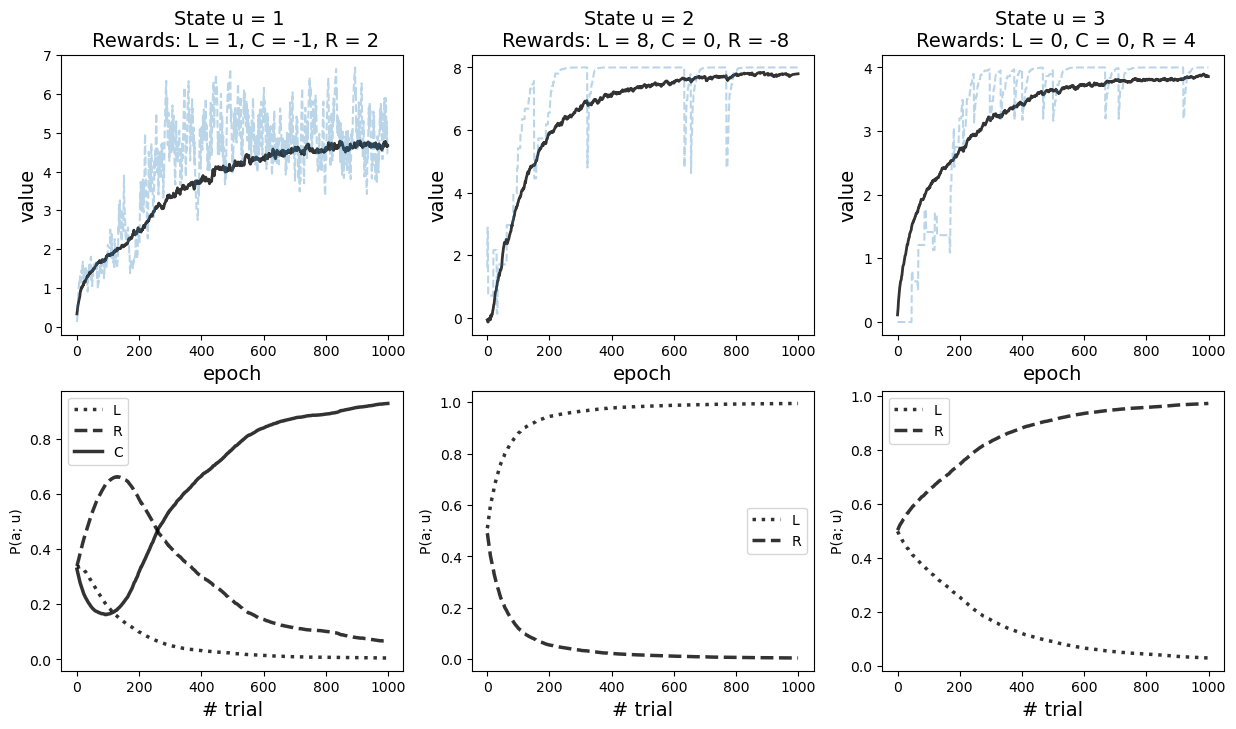

In [26]:
values = np.array(epochValues.mean(axis=0))
probs = np.array(epochProbabilites.mean(axis=0))
FONTSIZE = 14
linewidth = 2.5
color='black'

with plt.style.context('default'):
    
    fig, axes = plt.subplots(2, 3, figsize=(15, 8))
    
    for i_state in [0, 1, 2]:
        
        ax = axes[0, i_state]
        ax.plot(values[:, i_state], color='black', linewidth=2, alpha=0.8)
        ax.plot(epochValues[-1, :, i_state], linestyle='dashed', alpha=0.3)
        #ax.set_xlabel("epoch", fontsize=FONTSIZE)
        ax.set_ylabel("value", fontsize=FONTSIZE)
        r = agent.reward_matrix[i_state]
        ax.set_title(f"State u = {i_state+1} \n Rewards: L = {r[0]}, C = {r[1]}, R = {r[2]}", fontsize=FONTSIZE)
        
        
        ax = axes[1, i_state]
        ax.plot(probs[:, i_state, 0], label=r"L", linestyle=':', alpha=0.8, linewidth=linewidth, color=color)
        ax.plot(probs[:, i_state, 2], label=r"R", linestyle="--", alpha=0.8, linewidth=linewidth, color=color)
        if i_state == 0:
            ax.plot(probs[:, i_state, 1], label=r"C", linestyle='-', alpha=0.8, linewidth=linewidth, color=color)
        
        ax.set_xlabel("# trial", fontsize=FONTSIZE)
        ax.set_ylabel(r"P(a; u)", fontsize=FONTSIZE)
        ax.legend()

    plt.savefig("hw02_figure2_actor_critic.png", dpi=150, bbox_inches='tight')

In [ ]:
%matplotlib widget
import matplotlib.animation as animation

plt.rcParams['image.cmap'] = 'rainbow'

with plt.style.context('dark_background'):
    fig, ax = plt.subplots()

    line1, = ax.plot(learner.times, learner.trialValues[0], label='value-function')
    line2, = ax.plot(learner.times, learner.trialErrors[0], label='error-delta')
    line3, = ax.plot(learner.times, learner.trialRewards[0], label='reward')
    ax.legend()

    lim_low = np.min(np.min(np.array(learner.trialErrors))) - 0.5
    lim_high = np.max(np.max(np.array(learner.trialValues))) + 0.5
    ax.set_ylim((lim_low, lim_high))

    def animate(i_trial):
        line1.set_ydata(learner.trialValues[i_trial])
        line2.set_ydata(learner.trialErrors[i_trial])
        line3.set_ydata(learner.trialRewards[i_trial])
        return [line1, line2]


    ani = animation.FuncAnimation(
        fig, animate, interval=100, blit=True, save_count=50)

In [ ]:
values = np.array(epochProbabilites.mean(axis=0))

plt.plot(values[:, 0, 0], label=r"L", alpha=0.8)
plt.plot(values[:, 0, 1], label=r"C", linestyle='dashed', alpha=0.8)
plt.plot(values[:, 0, 2], label=r"R", linestyle="--", alpha=0.8)
plt.legend()